In [1]:
import pandas as pd
import numpy as np
import feather
import time
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

import xgboost as xgb

from sklearn.metrics import silhouette_samples
from matplotlib import cm

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings("ignore", category=DeprecationWarning)
print('Deprecation warning will be ignored!')

/Users/mshogo/miniconda3/envs/kaggle/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Deprecation warning will be ignored!


In [6]:
# count_df = pd.read_table('../data/Merged_Counts.tsv')
# feather.write_dataframe(count_df, '../data/adsc_Counts.feather')
# fpkm_df = pd.read_table('../data/Merged_FPKM.tsv')
# feather.write_dataframe(count_df, '../data/adsc_fpkm.feather')
# fpkm_uq_df = pd.read_table('../data/Merged_FPKM-UQ.tsv')
# feather.write_dataframe(count_df, '../data/adsc_uq_fpkm.feather')

In [5]:
clinical_df = pd.read_table('../data/LUNG_clinicalMatrix', index_col=0)
clinical_columns_dict = {
    'sampleID': 'tcga_id',
#    '_primary_disease': 'primary',
    'gender': 'gender',
#     'sample_type': 'tcga_type',
#     'Expression_Subtype': 'exp_sub',
}
clinical_df = clinical_df.filter(items=clinical_columns_dict.keys())
clinical_df = clinical_df.rename(columns=clinical_columns_dict)
#clinical_df['primary'] = clinical_df['primary'].replace( {'lung adenocarcinoma': 'LUAD', 'lung squamous cell carcinoma': 'LUSC'} )
print(clinical_df.shape)
clinical_df.head()

(1299, 1)


,gender
sampleID,
TCGA-05-4244-01,MALE
TCGA-05-4249-01,MALE
TCGA-05-4250-01,FEMALE
TCGA-05-4382-01,MALE
TCGA-05-4384-01,MALE


In [42]:
adsc_raw_df = pd.read_feather('../data/adsc_Counts.feather')
adsc_df = adsc_raw_df.drop(adsc_raw_df.iloc[-5:, :].index, axis=0)
adsc_df = adsc_df.rename(columns={'Unnamed: 0': 'geneID'})
adsc_df = adsc_df.drop(['gene_name'], axis=1).set_index('geneID')
adsc_df.columns = [name[:15] for name in adsc_df.columns]
adsc_df = adsc_df.T.groupby(level=0).last() 
print(adsc_df.shape)
adsc_df.head()

(1124, 60483)


geneID,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000263980.4,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1
TCGA-05-4244-01,5027,0,1460,1500,867,1978,2983,4504,3129,3113,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4249-01,4415,0,2019,1891,519,1220,2758,3588,1582,6987,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4250-01,5355,5,2898,734,785,1484,4541,5274,2845,3697,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4382-01,3898,0,2832,1192,793,4687,8694,8710,5934,4073,...,0,0,0,0,0,0,0,0,0,0
TCGA-05-4384-01,1347,0,910,986,209,1053,1533,1696,6634,1272,...,0,0,0,0,0,0,0,0,0,0


# 値全体補正 + 列選択
### 1.値全体補正：MinMaxScaler
### 2.列選択 : geneごとに値が0の場合、半分以上を削除、MAD上位10000

In [31]:
adsc_mtx = MinMaxScaler().fit_transform(adsc_df.values)
adsc_minmax_df = pd.DataFrame(adsc_mtx, index=adsc_df.index, columns=adsc_df.columns)

In [32]:
no_name = [name for name in adsc_minmax_df.index if not name in clinical_df.index]
no_name

[]

In [33]:
del_list = [name for name in list(adsc_minmax_df.columns) if adsc_minmax_df[name].isin([0]).sum() > int(adsc_minmax_df.shape[0]/2)]
adsc_minmax_df.drop(del_list, axis=1, inplace=True)
print(adsc_minmax_df.shape)
adsc_minmax_df.head()

(1124, 32065)


geneID,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSG00000281855.1,ENSG00000281881.1,ENSG00000281883.1,ENSG00000281892.1,ENSG00000281896.1,ENSG00000281902.1,ENSG00000281903.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1
TCGA-05-4244-01,0.106701,0.00000,0.128714,0.255261,0.194291,0.111932,0.038515,0.189810,0.025400,0.112701,...,0.040650,0.333333,0.15,0.285714,0.206897,0.250,0.015330,0.121753,0.03125,0.126866
TCGA-05-4249-01,0.093407,0.00000,0.190001,0.331450,0.114180,0.068198,0.035450,0.146517,0.012470,0.278143,...,0.000000,0.085106,0.15,0.000000,0.142857,0.250,0.017689,0.032468,0.03125,0.007463
TCGA-05-4250-01,0.113826,0.00061,0.286372,0.106002,0.175414,0.083429,0.059741,0.226203,0.023026,0.137641,...,0.012195,0.042553,0.00,0.000000,0.091133,0.125,0.022406,0.038961,0.03125,0.022388
TCGA-05-4382-01,0.082177,0.00000,0.279136,0.195246,0.177256,0.268232,0.116322,0.388600,0.048844,0.153698,...,0.010163,0.007092,0.25,0.142857,0.142857,0.000,0.016509,0.094156,0.00000,0.111940
TCGA-05-4384-01,0.026762,0.00000,0.068414,0.155105,0.042818,0.058562,0.018760,0.057094,0.054695,0.034079,...,0.012195,0.166667,0.10,0.095238,0.068966,0.000,0.004717,0.030844,0.00000,0.007463


In [34]:
num_mad_genes = 10000
mad_genes = adsc_minmax_df.mad(axis=0).sort_values(ascending=False)
top_mad_genes = mad_genes.iloc[0:num_mad_genes, ].index
adsc_minmax_df = adsc_minmax_df.loc[:, top_mad_genes] 
print(adsc_minmax_df.shape)
adsc_minmax_df.head()

(1124, 10000)


geneID,ENSG00000266640.1,ENSG00000152413.13,ENSG00000139726.9,ENSG00000114999.7,ENSG00000126456.14,ENSG00000113460.11,ENSG00000132842.12,ENSG00000160194.16,ENSG00000281902.1,ENSG00000125952.17,...,ENSG00000104356.9,ENSG00000140950.14,ENSG00000225791.5,ENSG00000270248.1,ENSG00000157379.12,ENSG00000280374.1,ENSG00000163145.11,ENSG00000235703.4,ENSG00000111788.10,ENSG00000183171.5
TCGA-05-4244-01,0.500000,0.403692,0.350431,0.202607,0.663810,0.243815,0.596568,0.453983,0.250,0.343650,...,0.156208,0.093860,0.153995,0.068182,0.242595,0.400922,0.026618,0.494978,0.158537,0.305556
TCGA-05-4249-01,0.166667,0.098920,0.414984,0.201859,0.453363,0.111461,0.594314,0.295595,0.250,0.367291,...,0.132844,0.176931,0.214589,0.363636,0.205660,0.105991,0.080460,0.103300,0.020606,0.027778
TCGA-05-4250-01,0.000000,0.324277,0.404847,0.186471,0.240698,0.201416,0.410822,0.447235,0.125,0.387392,...,0.137294,0.172348,0.115014,0.045455,0.087421,0.299539,0.017241,0.040890,0.020185,0.013889
TCGA-05-4382-01,0.166667,0.364681,0.342504,0.491879,0.730059,0.150188,0.532315,0.402062,0.000,0.721905,...,0.159324,0.233076,0.279043,0.409091,0.127473,0.202765,0.077737,0.113343,0.259882,0.201389
TCGA-05-4384-01,0.166667,0.222222,0.123390,0.108784,0.154684,0.050791,0.208166,0.196626,0.000,0.144016,...,0.039608,0.092333,0.138942,0.045455,0.132630,0.156682,0.068361,0.065280,0.090833,0.090278


In [35]:
merge_df = pd.concat([adsc_minmax_df, clinical_df], axis=1, join_axes=[adsc_minmax_df.index])
adsc_minmax_df = merge_df.dropna(subset=['gender'])
adsc_sample_df = adsc_minmax_df.sample(frac=0.2)
print(adsc_sample_df.shape)
adsc_sample_df.head()

(225, 10001)


,ENSG00000266640.1,ENSG00000152413.13,ENSG00000139726.9,ENSG00000114999.7,ENSG00000126456.14,ENSG00000113460.11,ENSG00000132842.12,ENSG00000160194.16,ENSG00000281902.1,ENSG00000125952.17,...,ENSG00000140950.14,ENSG00000225791.5,ENSG00000270248.1,ENSG00000157379.12,ENSG00000280374.1,ENSG00000163145.11,ENSG00000235703.4,ENSG00000111788.10,ENSG00000183171.5,gender
TCGA-66-2737-01,0.000000,0.273772,0.308894,0.403398,0.392558,0.232625,0.465306,0.409185,0.000,0.326519,...,0.213501,0.172134,0.045455,0.079986,0.046083,0.049909,0.207317,0.122792,0.034722,MALE
TCGA-LA-A446-01,0.666667,0.413793,0.323375,0.528211,0.187355,0.382726,0.364228,0.212933,0.000,0.155208,...,0.172348,0.203782,0.068182,0.096175,0.156682,0.008469,0.302009,0.309083,0.027778,MALE
TCGA-18-3421-01,0.000000,0.152560,0.350278,0.196730,0.244530,0.465950,0.038953,0.517151,0.000,0.273184,...,0.039244,0.239676,0.000000,0.113443,0.041475,0.004235,0.017217,0.049201,0.020833,MALE
TCGA-97-8552-01,0.333333,0.147684,0.071946,0.065078,0.292629,0.043972,0.146418,0.273290,0.125,0.120603,...,0.026926,0.102277,0.022727,0.134908,0.032258,0.107683,0.247489,0.022288,0.104167,FEMALE
TCGA-69-7979-01,0.166667,0.145942,0.336407,0.293973,0.367349,0.341289,0.318262,0.333083,0.000,0.439927,...,0.117636,0.188344,0.136364,0.316944,0.221198,0.010889,0.269010,0.165265,0.090278,FEMALE


In [36]:
test_df = adsc_sample_df['gender'].map({'MALE': 0, 'FEMALE': 1})
train_df = adsc_sample_df.drop(['gender'], axis=1)
model = xgb.XGBRegressor()
model.fit(train_df.values, test_df.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

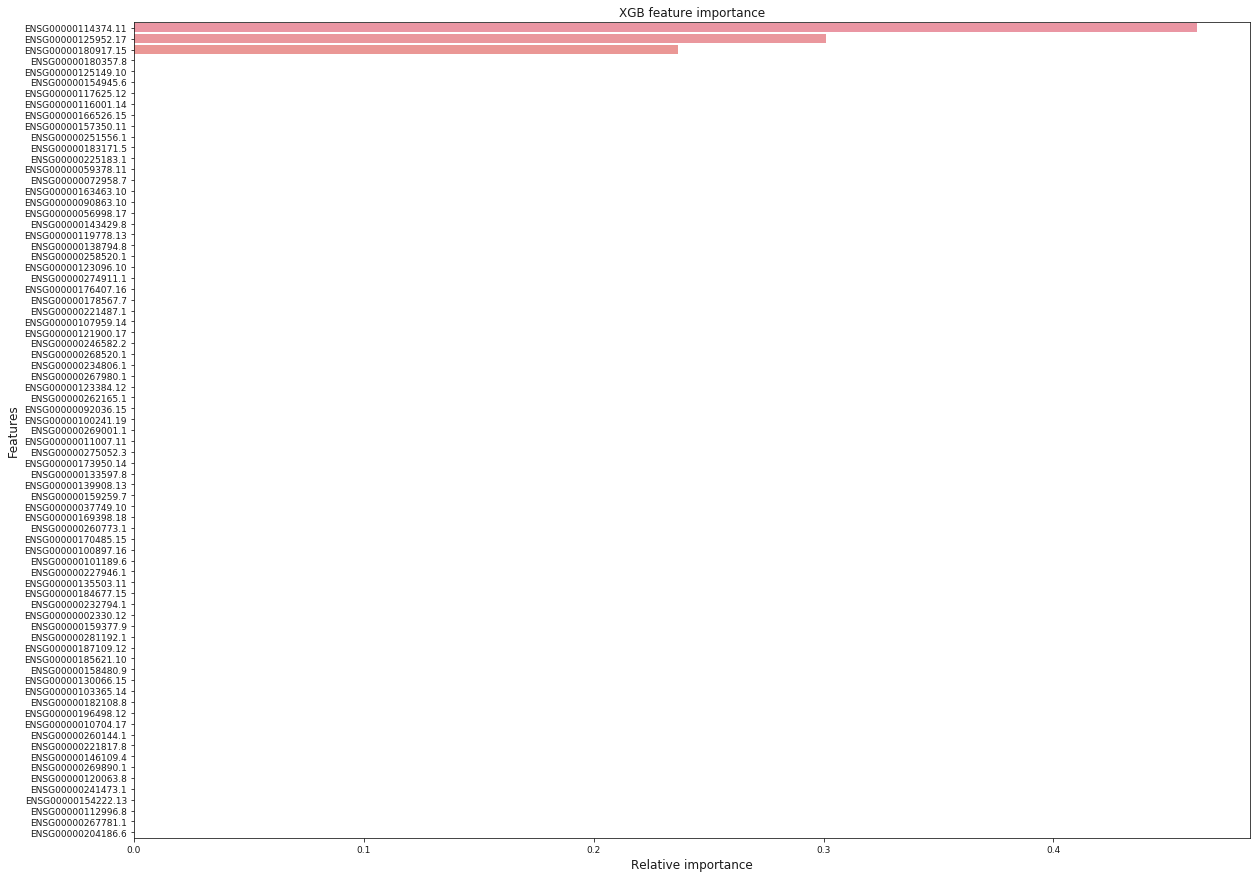

In [37]:
indice = np.argsort(model.feature_importances_)[::-1]
indice = indice[:75]

plt.subplots(figsize=(20, 15))
g = sns.barplot(y=adsc_minmax_df.columns[indice], x=model.feature_importances_[indice], orient='h')
g.set_xlabel('Relative importance', fontsize=12)
g.set_ylabel('Features', fontsize=12)
g.tick_params(labelsize=9)
g.set_title('XGB feature importance');

In [84]:
adsc_raw_df.set_index('Unnamed: 0').loc[list(adsc_minmax_df.columns[indice[0:3]]),:]

,gene_name,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,TCGA-05-4396-01A-21R-1858-07,...,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-S2-AA1A-01A-12R-A39D-07,TCGA-XC-AA0X-01A-32R-A405-07
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000114374.11,USP9Y,352,1860,1,1399,1568,182,1,917,1446,...,1546,0,1802,0,0,0,184,0,0,0
ENSG00000125952.17,MAX,3797,4004,4180,7109,2049,5886,3228,5430,1088,...,1677,3483,4012,4775,2721,3166,3404,5486,2074,2724
ENSG00000180917.15,CMTR2,2796,2403,2631,2669,1299,2352,672,2372,1692,...,515,1753,764,1294,1532,1756,664,2262,1046,1024


In [38]:
sss = StratifiedShuffleSplit(test_df, 10, test_size=0.2, random_state=23)
for train_index, test_index in sss:
    X_train, X_test = train_df.values[train_index], train_df.values[test_index]
    y_train, y_test = test_df[train_index], test_df[test_index]

In [39]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 60.0000%
Log Loss: 3.538048647433569
SVC
****Results****
Accuracy: 60.0000%
Log Loss: 0.6531744792289149
NuSVC
****Results****
Accuracy: 68.8889%
Log Loss: 0.5723909239198341
DecisionTreeClassifier
****Results****
Accuracy: 100.0000%
Log Loss: 9.992007221626415e-16
RandomForestClassifier
****Results****
Accuracy: 88.8889%
Log Loss: 0.32711075447675153
AdaBoostClassifier
****Results****
Accuracy: 100.0000%
Log Loss: 9.796464624833222e-06
GradientBoostingClassifier
****Results****
Accuracy: 100.0000%
Log Loss: 0.0003016708651752481
GaussianNB
****Results****
Accuracy: 88.8889%
Log Loss: 3.837641821656743
LinearDiscriminantAnalysis
****Results****
Accuracy: 53.3333%
Log Loss: 1.223410500761362
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 48.8889%
Log Loss: 17.653152379621016


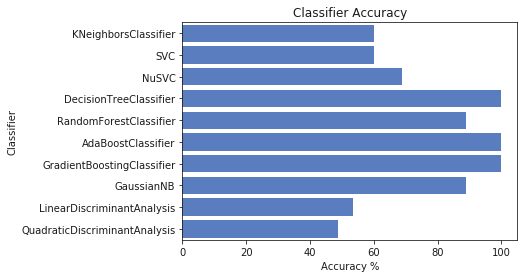

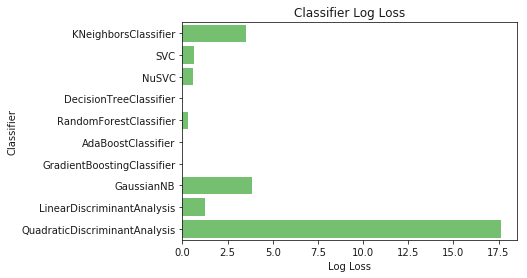

In [40]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

In [41]:
indice

1325

In [45]:
adsc_raw_df.head()

,Unnamed: 0,gene_name,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,...,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-S2-AA1A-01A-12R-A39D-07,TCGA-XC-AA0X-01A-32R-A405-07
0,ENSG00000000003.13,TSPAN6,5027,4415,5355,3898,1347,9168,2322,3136,...,1813,2736,1107,3698,3279,2837,4427,5571,4744,2193
1,ENSG00000000005.5,TNMD,0,0,5,0,0,1,0,0,...,1,0,0,9,0,0,0,0,2,0
2,ENSG00000000419.11,DPM1,1460,2019,2898,2832,910,2224,1338,3206,...,2369,1591,1757,1816,4271,1745,2474,2393,1034,1702
3,ENSG00000000457.12,SCYL3,1500,1891,734,1192,986,1288,452,1544,...,554,955,532,509,1685,677,864,3669,893,565
4,ENSG00000000460.15,C1orf112,867,519,785,793,209,851,543,521,...,415,407,522,392,2121,833,781,3922,181,338


,gene_name,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,TCGA-05-4396-01A-21R-1858-07,...,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-S2-AA1A-01A-12R-A39D-07,TCGA-XC-AA0X-01A-32R-A405-07
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ENSG00000114374.11,USP9Y,352,1860,1,1399,1568,182,1,917,1446,...,1546,0,1802,0,0,0,184,0,0,0
ENSG00000125952.17,MAX,3797,4004,4180,7109,2049,5886,3228,5430,1088,...,1677,3483,4012,4775,2721,3166,3404,5486,2074,2724
ENSG00000180917.15,CMTR2,2796,2403,2631,2669,1299,2352,672,2372,1692,...,515,1753,764,1294,1532,1756,664,2262,1046,1024
